In [ ]:
#%pip install ipywidgets
#%pip install voila
#%pip install voila-gridstack
### 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas.util.testing as tm
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import ipywidgets as wdg
from IPython.display import display
from ipywidgets import GridspecLayout

In [ ]:
### input data
## data filename
datafilename1 = 'sepsis_survival_primary.csv'
datafilename2 = 'sepsis_survival_study.csv'
datafilename3 = 'sepsis_survival_validation.csv'

## depended Variable column name
dependVar = 'hospital_outcome_1alive_0dead'
## exclude columns from analyze (text, urls, etc. )
excludeColumns = []
## minimum correlation coeff to assume as a key variable
minimumCorrCoef = 0.01
threshold = 0.5


In [ ]:
## read CSV file, autodetect delimeters, skip spaces in names
df1 = pd.read_csv(datafilename1, sep=None, engine="python", skipinitialspace=True)
df2 = pd.read_csv(datafilename2, sep=None, engine="python", skipinitialspace=True)
df3 = pd.read_csv(datafilename3, sep=None, engine="python", skipinitialspace=True)
dfs = [df1, df2, df3]
df1.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1


In [ ]:
for df in dfs:
    ## exclude columns
    df.drop(excludeColumns, axis ='columns', inplace = True)
    ## and drop  all NaN
    df.dropna(inplace=True)
    ## place depended var into pos 0
    poped = df.pop(dependVar)
    df.insert(0, poped.name, poped)
    #how many values are missing
    print("Total NaN: ",df.isnull().sum().sum())
          #df.isnull().sum())
        
## independed variable columns names  
independVarList = list(df.columns.values)
independVarList.remove(dependVar)
dfclean = df.copy()

Total NaN:  0
Total NaN:  0
Total NaN:  0


In [ ]:
allVars=dfclean.columns
####WORK ON THIS ONE!!!!!
##PUT widgets horizontally
nxdr = wdg.Dropdown(options = allVars, value = allVars[1], 
                    description = 'X value', option = 'X var')

nBinsdr = wdg.Dropdown(options=[2,10,15,20,40], value=2, 
                    description = 'Bins number', option = 'Bin value')

def plot_histogram(x = 'age_years', nBins = 15, PlotKDE = False):    
    sns.histplot(data = dfclean[x] , bins = nBins, kde = PlotKDE)

out = wdg.interact(plot_histogram, nBins = nBinsdr,PlotKDE = False,x=nxdr)
ui = wdg.HBox([nxdr,nBinsdr])

interactive(children=(Dropdown(description='X value', index=1, options=('hospital_outcome_1alive_0dead', 'age_…

In [ ]:
dftrain = dfclean.sample(frac=0.8, random_state = 200) #training data set (80%)
dftest = dfclean.drop(dftrain.index) #testing data set (20%)

In [ ]:
allVars=dfclean.columns
####WORK ON THIS ONE!!!!!
##PUT widgets horizontally
nxdr2x = wdg.Dropdown(options = allVars, value = allVars[1], 
                    description = 'X value', option = 'X var')
nxdr2y = wdg.Dropdown(options = allVars, value = allVars[1], 
                    description = 'X value', option = 'X var')

def plot_scatterplot(x = 'age_years', y = 'hospital_outcome_1alive_0dead'):    
    sns.scatterplot(data = dfclean , x = x, y = y)

out2 = wdg.interact(plot_scatterplot, x=nxdr2x, y = nxdr2y)
ui = wdg.HBox([nxdr2x,nxdr2y])


interactive(children=(Dropdown(description='X value', index=1, options=('hospital_outcome_1alive_0dead', 'age_…

## Regular regressional analise through all possible variables

In [ ]:
def HeatmapCorr(df): 
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.set_theme(style="white")
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Custom colormap
    cmap = sns.diverging_palette(275, 150, s=90, l=50, n=9, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap,  linewidths=0.3, cbar_kws={"shrink":0.5})

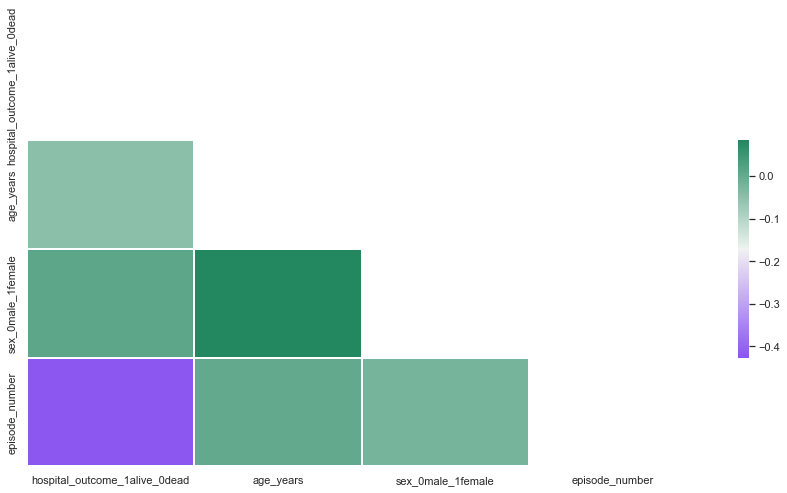

In [ ]:
HeatmapCorr(df3)

In [ ]:
def GetKeyVariables(df):
    parCorr = pd.DataFrame(df.corr() )
    n = len(parCorr.columns)
    keyVars = pd.DataFrame(columns=['key', 'val'])
    ## depended variable moved to index 0
    i = 0
    for j in range( n):
        if j >= i:
            keyVars = keyVars.append({'key':parCorr.columns[j],'val':parCorr.iloc[i, j]}, ignore_index=True)
    ## sort key vars by value
    keyVars.pop(df.columns[0])
    keyVars.sort_values(by='val', key=abs, ascending=False, inplace=True)
    return keyVars

#display(GetKeyVariables(dftrain[[dependVar, *set1]]))
#display(GetKeyVariables(dftrain[[dependVar, *set2]]))
#display(GetKeyVariables(dftrain[[dependVar, *set3]]))
#display(GetKeyVariables(dftrain[[dependVar, *set4]]))
#display(GetKeyVariables(dftrain[[dependVar, *set5]]))
#display(GetKeyVariables(dftrain))


In [ ]:
#for1 = dftrain.columns[4]+'~'+dftrain.columns[4]

In [ ]:
#mod = smf.ols(formula=for1, data = dftrain)
#res = mod.fit()
#res.summary()

In [ ]:

def LogRegModel(independVarList):
    indepVars = ''
    for i in range(0,len(independVarList)-1):
        indepVars+=independVarList[i]
        indepVars+=" + "
    indepVars+=independVarList[-1]
    depVar = dependVar
    model = smf.logit(formula = depVar+' ~ '+ indepVars,data = dftrain)
    res = model.fit()
    print(depVar,'~',indepVars,':',
              round(res.prsquared,5))#McFadden's pseudo-R-squared.
    """
    inSample = pd.DataFrame({'prob':res.predict(dftest[independVarList])}) #probabilities 
    inSample['predLabel'] = (inSample['prob'] > threshold).astype(int) #labels based on probabilities
    inSample.head()
    confMatrix = pd.crosstab(inSample['predLabel'],dftest[depVar])
    #sns.heatmap(confMatrix, annot = True)                  
    #plt.show()
    #calculation of BA 
    BA=0
    TN = confMatrix.loc[0,0]
    FN = confMatrix.loc[0,1]
    FP = confMatrix.loc[1,0]
    TP = confMatrix.loc[1,1]
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    BA = (TPR + TNR)/2
    print(f'BA = {BA:0.4f}')
    """
def LogRegModelSqrt(independVarList):
    indepVars = ''
    for i in range(0,len(independVarList)-1):
        indepVars+='np.power('+independVarList[i]+',2)'
        indepVars+=" + "
    indepVars+='np.power('+independVarList[-1]+',2)'
    depVar = dependVar
    model = smf.logit(formula = depVar+' ~ '+ indepVars,data = dftrain)
    res = model.fit()
    print(depVar,'~',indepVars,':',
              round(res.prsquared,5))#McFadden's pseudo-R-squared.

In [ ]:
#LogRegModel(independVarList)
#LogRegModel(independVarList[0:1])
#LogRegModel(independVarList[1:2])
#LogRegModel(independVarList[2:3])

In [ ]:
#LogRegModelSqrt(independVarList)
#LogRegModelSqrt(independVarList[0:1])
#LogRegModelSqrt(independVarList[1:2])
#LogRegModelSqrt(independVarList[2:3])

In [ ]:
df_scaled = (dftrain - dftrain.min())/(dftrain.max() - dftrain.min())

In [ ]:
x = dftrain[["age_years","sex_0male_1female","episode_number"]]
y = dftrain["hospital_outcome_1alive_0dead"]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def optimize(x, y,learning_rate,iterations,parameters): 
    size = x.shape[0]
    weight = parameters["weight"] 
    bias = parameters["bias"]
    for i in range(iterations): 
        sigma = sigmoid(np.dot(x, weight) + bias)
        loss = -1/size * np.sum(y * np.log(sigma)) + (1 - y) * np.log(1 - sigma)
        dW = 1/size * np.dot(x.T, (sigma - y)) 
        db = 1/size * np.sum(sigma - y)
        weight -= learning_rate * dW
        bias -= learning_rate * db 
    
    parameters["weight"] = weight
    parameters["bias"] = bias
    return parameters
# Initialize the weight and bias
init_parameters = {} 
init_parameters["weight"] = np.zeros(x.shape[1])
init_parameters["bias"] = 0

def train(x, y, learning_rate,iterations):
    parameters_out = optimize(x, y, learning_rate, iterations ,init_parameters)
    return parameters_out
# Train the model
parameters_out = train(x, y, learning_rate = 0.02, iterations = 500)
parameters_out


C:\Users\ilia\AppData\Local\Temp\ipykernel_25568\167531096.py:13: RuntimeWarning: divide by zero encountered in log
  loss = -1/size * np.sum(y * np.log(sigma)) + (1 - y) * np.log(1 - sigma)


{'weight': array([ 0.05251083,  0.12424849, -0.44082973]),
 'bias': 0.06038909748790655}

In [ ]:
#Predict
#print(len(df3))
df3_scaled = (df3 - dftrain.min())/(dftrain.max() - dftrain.min())
 #- df3.min())/(df3.max() - df3.min())
x = df3_scaled[["age_years","sex_0male_1female","episode_number"]]
y = df3_scaled["hospital_outcome_1alive_0dead"]
output_vals = np.dot(x,parameters_out["weight"]) + parameters_out["bias"]
predictions = sigmoid(output_vals) >= 1/2
#print(len(predictions))

In [ ]:
#np.array(df['hospital_outcome_1alive_0dead'])

In [ ]:
countT=0
countF=0
for i in np.array(predictions==np.array(df3_scaled['hospital_outcome_1alive_0dead'])):
    if i ==True:
        countT += 1
    elif i== False: 
        countF +=1
print(countF,countT, "Prediction accuracy:", countT/(countT+countF))

22 115 Prediction accuracy: 0.8394160583941606


In [ ]:
i,j = 4,4
grid = GridspecLayout(i,j)
dfval = dftrain[["age_years","sex_0male_1female","episode_number"]] 
#print(dfval.min())
def create_expanded_button(description, button_style):
    return wdg.Button(description=description, button_style=button_style,
                      layout=wdg.Layout(height='auto', width='auto'))


grid[2, 0] = create_expanded_button('Send'.format(0, 0), 'warning')
grid[2, 1] = create_expanded_button('Clear'.format(0, 0), 'warning')
btn_sex = grid[0,0] = wdg.Dropdown(description='Sex', options =['Female','Male'])
btn_age = grid[0,1] = wdg.Dropdown(description='Age', options =range(26,100))
btn_episodes = grid[0,2] = wdg.Dropdown(description='Episodes number', options =range(1,5))

btn_outcome = grid[1,0] = wdg.Text(value='.......', description='Outcome')

def evaluate():
    Alist = 0
    print('Sex:',btn_sex.value,
          ', Age:',btn_age.value,
          ', Episode Number',btn_episodes.value)
    sex_value = 1
    if btn_sex.value == 'Female':
        sex_value = 1
    else:
        sex_value = 0
    
    Alist = np.array([btn_age.value,sex_value,btn_episodes.value])
    print(Alist)
  
    Alist_scaled = (Alist - dfval.min())/(dfval.max() - dfval.min())   
    print(Alist_scaled)
    x = Alist_scaled
    output_vals = np.dot(x,parameters_out["weight"]) + parameters_out["bias"]
    predictions = sigmoid(output_vals) >= 1/2
    if predictions == True:
         btn_outcome.value = 'ALIVE'
    elif predictions ==False:
        btn_outcome.value = 'DEAD'
    
def clear():
    print('clear')
        

def on_btn_click(btn):
    if btn.description == 'Send':
        evaluate()
    elif btn.description == 'Clear':
        clear()

for j in range(2):
    grid[2,j].on_click(on_btn_click)

grid

GridspecLayout(children=(Button(button_style='warning', description='Send', layout=Layout(grid_area='widget001…